Created: 27-05-2022, Last-Updated: 17-06-2022
# Problem Set 3 (Soft Policy Iteration)
## Student: Philine Meyjohann

The goal of this problem set is to study the convergence properties of an RL algorithm we covered in class: Soft Policy Iteration. This algorithm performs a sequence of iterations $k=1,2, \ldots$ where the following operations are repeated:
1. Execute policy $\pi_{k}$ and gather $T$ sample transitions $\left(\left(x_{k, 1}, a_{k, 1}, r_{k, 1}\right), \ldots,\left(x_{k, T}, a_{k, T}, r_{k, T}\right)\right)$,
2. using the above samples, build estimate $\widehat{Q}_{k}$ of the action value function $Q^{\pi_{k}}$,
3. update policy $\pi_{k+1}(a \mid x)=\frac{\pi_{k}(a \mid x) e^{\eta \hat{Q}_{k}(x, a)}}{\sum_{a^{\prime}} \pi_{k}\left(a^{\prime} \mid x\right) e^{\eta \hat{Q}_{k}\left(x, a^{\prime}\right)}}$, where $\eta>0$ is a stepsize (or learning-rate) parameter.

These updates are soft in the sense that they interpolate between greedy policy updates (corresponding to $\eta=+\infty)$ and making no update $(\eta=0)$. The purpose of setting finite values of $\eta$ is to deal with the effects of errors in approximating $Q^{\pi_{k}}$. As we have seen from the theoretical guarantees presented in class, choosing $\eta$ to be too large or too small may result in poor performance: small values of $\eta$ will result in slow convergence, whereas large values of $\eta$ may result in unstable performance due to overly greedy updates. The purpose of this exercise is to show that these effects may indeed impact the empirical performance of this algorithm.

You are specifically asked to implement soft policy iteration in the MDP used in the previous exercises, and use LSTD with the piecewise linear feature map as a subroutine for approximate policy evaluation.


### Definitions
The definition of the MDP to be used is the following:
+ **The state space** consists of the integers $0, 1, 2, ..., N-1$, with $N=100$, corresponding to the length of the queue.
+ **The action space** consists of two actions: action $a_{low}$ corresponding to a low service rate
of $q(a_{low})= q_{low} = 0.51$ and action $a_{high}$ corresponding to a high service rate of $q(a_{high}) = q_{high} = 0.6$.
+ **The reward function** assigns a reward of $r(x,a) = -(x/N)^2-c(a)$, with $c(a)$ being the cost of action $a$. This cost is defined for the two actions as $c(a_{low}) = 0$ and $c(a_{high}) = 0.01$.
+ **The transition function** describes the dynamics of the queue as follows. The arrival rate $p = 0.5$ models the rate at which new requests arrive into the queue and the controlled service rate models the rate at which requests leave the queue. In each round, the queue length increases by 1 with probability p and decreases by 1 with probability $q(a)$ corresponding to the action $a$ taken. Precisely, letting $x_t$ be the current queue length, $a_t$ be the action taken by the agent, we define $I_t \in \{0,1\}$ as the increment such that $P[I_t = 1] = p$ and $S_t \in \{0,1\}$ as the decrement such that $P[S_t = 1] = q(a_t)$, the queue length is updated in each round as $$x_{t+1} = trunc(x_t + I_t - S_t),$$ where the “trunc” operator truncates the value to the interval $[0,N-1]: trunc(x) = \min \{N-1, \max\{x,0\}\}$.
+ **The discount factor** will be set as $\gamma = 0.9$.

For LSTD, please use the piecewise linear feature map used in the previous problem set, whose definition is recalled below:
+ **A coarse feature map**: an $N / 5$-dimensional feature vector with its $i$-th component defined as $$\phi_{i}^{\text {coarse }}(x)=\mathbf{1}\{x \in[5(i-1), 5 i-1]\}.$$ This feature map can represent piecewise constant functions on the state space.
+ **A piecewise linear feature map**: an $2 \times N / 5$-dimensional feature vector with its first $N / 5$ entries being equal to the previous feature map (i.e., $\phi_{i}^{\text {pwl }}=\phi_{i}^{\text {coarse }}$ for $i=1,2, \ldots, N / 5$ ) and the second $N / 5$ entries defined as $$ \phi_{N / 5+i}^{\mathrm{pwl}}(x)=\mathbf{1}\{x \in[5(i-1), 5 i-1]\} \cdot(x-5(i-1)) / 5,$$ for $i=1,2, \ldots, N / 5$. The normalization constant $1 / 5$ is present to make sure that all features are bounded in $[0,1]$. This feature map can represent piecewise linear functions on the state space.

## Preliminaries

In [1]:
# import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

np.random.seed(123)

In [2]:
# define basic properties
N = 100
X = N # state space
A = 2 # action space
p = 0.5 # arrival rate
gamma = 0.9 # discount factor

# action space
q_low = 0.51
q_high = 0.6
q = [q_low, q_high]

# costs
c_low = 0
c_high = 0.01
c = [c_low, c_high]

### Define environment and possible functions

In [3]:
# define possible states for plots
states = np.linspace(0,N-1,N).astype('int')
states

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [4]:
# define reward
reward = np.zeros((X, A))
for a in range(A):
    for x in range(X):
        reward[x,a] = -(x/N)**2 - c[a]

In [5]:
# constructs a transition model P for queue environment with size (N,N)
# P[x,y,a] gives the probability of moving from state x to state y when taking action a
def move(x,delta_x,N): # 
    new_x = x + delta_x
    return np.maximum(np.minimum(new_x,N-1),0)


def queue_env(N): # constructs X by X transition matrix for policy pi
    P = np.zeros((N, N, A)) 
    for x in range(0,N):
        for y in range(0,N):
            for a in range(0,A):
                if y == move(x,0,N):
                    # Edge case 1: no-one in the queue
                    if x == 0:
                        P[x,y,a] = 1 - ((1-q[a])*p)
                    # Edge case 2: full queue
                    elif x == N-1:
                        P[x,y,a] = 1 - (q[a]*(1-p))
                    # No edge cases
                    else:
                        P[x,y,a] = (1-q[a])*(1-p) + q[a]*p
                elif y == move(x,1,N):
                    P[x,y,a] = (1-q[a])*p
                elif y == move(x,-1,N):
                    P[x,y,a] = q[a]*(1-p)
    return P

In [6]:
P = queue_env(N)
P[:,:,1]

array([[0.8, 0.2, 0. , ..., 0. , 0. , 0. ],
       [0.3, 0.5, 0.2, ..., 0. , 0. , 0. ],
       [0. , 0.3, 0.5, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0.2, 0. ],
       [0. , 0. , 0. , ..., 0.3, 0.5, 0.2],
       [0. , 0. , 0. , ..., 0. , 0.3, 0.7]])

In [7]:
# transition matrix for policy pi
def transition(P,pi):
    X = np.size(P,0)
    P_pi = np.zeros((X,X))
    for x in range(X):
        for y in range(X):
            P_pi[x,y]=P[x,y,0]*pi[x,0] + P[x,y,1]*pi[x,1]
    return P_pi

In [8]:
# coarse feature map
phi_coarse = np.zeros((N,int(N/5)))
for x in range(X):
    for i in range(0,len(phi_coarse)):
        if x in range((5*(i-1)), (5*i-1)+1):
            phi_coarse[x,i-1] = 1


# piecewise-linear feature map
pwl=np.zeros((X,int(N/5)))
for x in range(X):
    for i in range(1,int(N/5)+1):
        if (x>=5*(i-1)) & (x<=5*i-1):
            pwl[x,i-1]=1*(x-5*(i-1))/5

phi_pwl = np.concatenate([phi_coarse,pwl],axis=1)

In [9]:
np.set_printoptions(threshold=np.inf)
phi_pwl.shape

(100, 40)

## Problem: Soft policy iteration
Using the LSTD implementation from the previous problem set, implement a soft policy iteration method where the initial policy is set as the uniform policy $\pi_{1}(a \mid x)=1 /|A|$ and the following steps are repeated in each iteration $k=1,2, \ldots, K$ :

+ **Policy evaluation**: Evaluate the current policy $\pi_{k}$ using LSTD and $T$ sample transitions, and let $\widehat{V}_{k}$ denote the result. When generating the trajectories for LSTD, do not reset the initial state to a full queue, but continue where the previous trajectory left off; that is, for each $k>1$, set $x_{k, 1}=x_{k-1, T+1}$ with $x_{k-1, T+1} \sim P\left(\cdot \mid x_{k-1, T}, a_{k-1, T}\right)$.
+ **Policy improvement**: Define the $Q$-function estimate as
$$
\begin{aligned}
\widehat{Q}_{k}(x, a)=r(x, a) &+\gamma(1-p)\left(q(a) \widehat{V}_{k}(x-1)+(1-q(a)) \widehat{V}_{k}(x)\right) \\
&+\gamma p\left(q(a) \widehat{V}_{k}(x)+(1-q(a)) \widehat{V}_{k}(x+1)\right)
\end{aligned}
$$
and set the new policy for all $(x, a)$ using the formula
$$
\pi_{k+1}(a \mid x)=\frac{\pi_{k}(a \mid x) e^{\eta \hat{Q}_{k}(x, a)}}{\sum_{a^{\prime}} \pi_{k}\left(a^{\prime} \mid x\right) e^{\eta \hat{Q}_{k}\left(x, a^{\prime}\right)}}
$$

Run the algorithm for a range of $M$ values of the learning rate $\eta$ spanning the interval $[0.01,100]$ evenly on a logarithmic scale. (Such a range of values can be generated in numpy using the command "numpy.logspace $\left(-2,2\right.$, num=M)".) For each different $\eta_{m}$ in the range $m=1,2, \ldots, M$, record the total amount of reward gathered during learning: $\widehat{R}_{m}=\sum_{k=1}^{K} \sum_{t=1}^{T} r_{k, t}$.

Your task is to run the above experiment for the choices $T=10^{5}, K=100, M=100$ and plot the rewards as a function of $\eta$. (Hint: For a readable plot, it is recommendable to use a logarithmic scale on the $\eta$ axis, which you can do in matplotlib with the command "plt.xscale('log")" after plotting your function, or by using "plt. semilogx" instead of "plt.plot".) What is your interpretation of the results? Which values of $\eta$ perform poorly and which ones work well? Is there any improvement over "hard" approximate policy iteration for some value of $\eta$ ?

Remark: Note that the above specification does not exactly match a fully practical implementation of soft PI, since the goal was to keep things relatively simple for didactic purposes. In a practical situation, one is typically not able to calculate the Q-values from the value function estimates since the probabilities $p$ and $q$ may be unknown. Likewise, in a real application, you may not be able to afford a full loop over the state-action space to update the policies. In these cases, it is more practical to parametrize the Q-functions directly and estimate them via approximate DP methods, for instance LSTD for Q-functions (often called "LSTD-Q").

### LSTD

In [10]:
def LSTD(P,reward,gamma,pi,phi,T,x_0,sigma=10**-10):
    """LSTD.
    
    Runs the LSTD algorithm.
    
    Inputs:
    ------
    reward : rewards, np.array
    gamma : discount factor, float
    pi : policy, np.array
    phi : feature map, np.array
    T : sample transitions, int
    x_0 : initial state, int
    
    Returns:
    -------
    value : value function, np.array
    end_state : end_state, int
    r_t_sum : sum of rewards, float
    """

    A = np.zeros((phi.shape[1], phi.shape[1]))
    A_1 = np.linalg.inv(A + (sigma*np.identity(phi.shape[1])))
    b = np.zeros(phi.shape[1])
    
    x = x_0
    r = reward[:,0]*pi[:,0] + reward[:,1]*pi[:,1]
    r_t_sum = 0
    P_pi = transition(P,pi)

    for t in range(T):
        x_new = np.random.choice(list(range(X)), p=P_pi[x,:]) # initialize new state x'
        v = np.dot(A_1.T,phi[x,:] - gamma*phi[x_new,:])
        A_1 = A_1 - np.outer(np.dot(A_1, phi[x,:]), v.T)/(1 + np.dot(v, phi[x,:]))
        b += r[x]*phi[x,:]
        x = x_new # update states
        r_t_sum += r[x]
    
    theta = A_1.dot(b)
    value = phi.dot(theta)
    
    return value, x, r_t_sum

### Soft policy iteration

In [11]:
def soft_policy_iteration(P,reward,gamma,eta,phi,x_0,V,T,K):
    """ Soft policy iteration.
    
    Implements a soft policy iteration method.
    
    Inputs:
    ------
    reward : rewards, np.array
    gamma : discount factor, float
    eta : learning rate, float
    phi : feature map, np.array
    x_0 : initial state, int
    V : initial value function estimate (for intialisation), np.array
    T : sample transitions, int
    K : number of iterations, int
    
    Returns:
    -------
    V : value function, np.array
    pi_soft_greedy : final policy, np.array
    r_k_t_sum : sum of rewards, np.array
    """
    
    r_k_t_sum = 0 # cumulative rewards
    x = x_0 # initialize x
    pi_soft_greedy = np.ones((X,A))*(1/A) # initialize policy with 1/|A|

    for k in range(K):
        Q_estimate = np.zeros((X,A))
        for x in range(X):
            numerator = np.zeros((X,A))
            denominator = 0
            for a in range(A):
                # Edge case 1: no one in the queue
                if x == 0:
                    Q_estimate[x,a] = reward[x,a] + gamma*(1-p)*V[x] + gamma*p*(q[a]*V[x]+(1-q[a])*V[x+1])
                # Edge case 2: full queue
                elif x == (X-1):
                    Q_estimate[x,a] = reward[x,a] + gamma*(1-p)*(q[a]*V[x-1]+(1-q[a])*V[x]) + gamma*p*V[x]
                # No edge cases
                else:
                    Q_estimate[x,a] = reward[x,a] + gamma*(1-p)*(q[a]*V[x-1]+(1-q[a])*V[x]) + gamma*p*(q[a]*V[x]+(1-q[a])*V[x+1])
                    
                # calculate components of soft policy update
                numerator[x,a] = pi_soft_greedy[x,a]*np.exp(eta*Q_estimate[x,a])
                denominator += numerator[x,a]
                
            # update policy - soft update
            if denominator == 0:
                pi_soft_greedy[x,:] = pi_soft_greedy[x,:]
            else:
                pi_soft_greedy[x,:] = numerator[x,:]/denominator
                    
        V, x_new, r_t_sum = LSTD(P,reward,gamma,pi_soft_greedy,phi,T,x_0)
        r_k_t_sum += r_t_sum # calculate sum of rewards
        x = x_new # new state is the last state as determined by LSTD
        
    return V, pi_soft_greedy, r_k_t_sum
        

In [12]:
%%time

# run soft policy approximation algorithm
T = 10**5
K = 100
M = 10
etas = np.logspace(-2, 2, num = M)
cum_rewards = []
opt_values_saPI = []
opt_policies_saPI = []
labels_saPI = []

for eta in etas:
    opt_value_saPI, opt_policy_saPI, cum_reward_saPI = soft_policy_iteration(P,reward,gamma,eta,phi_pwl,X-1,np.zeros(X),T,K)
    cum_rewards.append(cum_reward_saPI)
    opt_values_saPI.append(opt_value_saPI)
    opt_policies_saPI.append(opt_policy_saPI)
    label_saPI = 'soft_aPI_' + str(round(eta, 2))
    labels_saPI.append(label_saPI)

CPU times: user 48min 40s, sys: 17min 39s, total: 1h 6min 20s
Wall time: 36min 7s


In [13]:
results_PI = pd.DataFrame(np.transpose(opt_values_saPI), columns=labels_saPI)

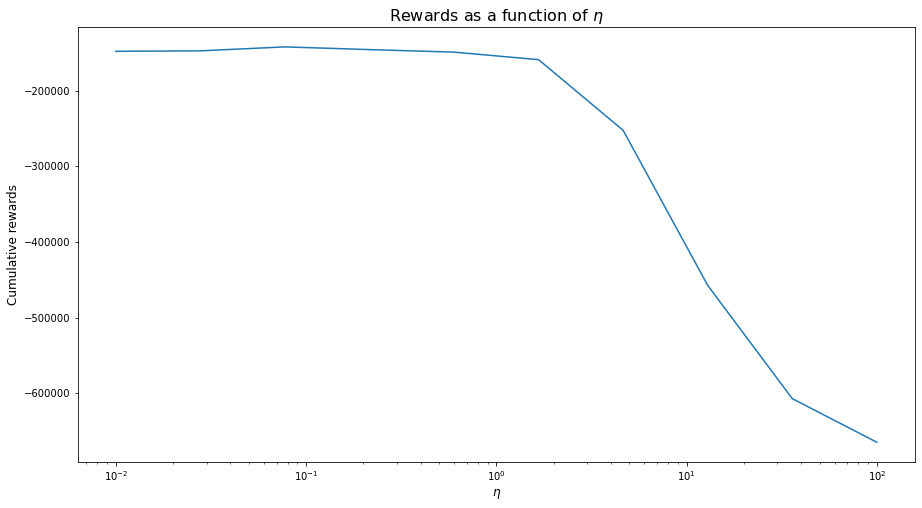

In [14]:
# plot the results
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(etas, cum_rewards)
plt.title("Rewards as a function of $\eta$", fontsize=16)
plt.xlabel("$\eta$", fontsize=12)
plt.ylabel("Cumulative rewards", fontsize=12)
plt.xscale('log')
plt.show()

In [15]:
max_eta = cum_rewards.index(max(cum_rewards))
min_eta = cum_rewards.index(min(cum_rewards))

print('Best eta: ', etas[max_eta])
print('Worst eta: ', etas[min_eta])

Best eta:  0.0774263682681127
Worst eta:  100.0


### Answer
***What is your interpretation of the results? Which values of $\eta$ perform poorly and which ones work well?***

Looking at the cumulative reward as a function of $\eta$ we can see that smaller values for $\eta$ outperform larger values. The difference in cumulative reward for values between 0.01 and 1 is small. However the cumulative reward drops sharply for values greater than 1. This reflects the fact that poor updates in the policy function incur smaller costs when the step-size parameter is small. This can be attributed to the fact that small etas stabilize the algorithm and lead to smoother updates. In contrast, poor updates weigh more heavy when we have a large step-size parameter as they take a more greedy approach to policy iteration. Whilst for deterministic process the greedy approach converges faster, it might get stuck in local optima when our process is highly stochastic. We thus face a tradeoff between greediness and the robustness of our results.

### "Hard" Approximate Policy Iteration

In [16]:
def approximate_policy_iteration(P,reward,gamma,phi,x_0,V,T,K):
    
    r_k_t_sum = 0 # cumulative rewards
    
    for k in range(K):
        V_next = -np.inf*np.ones(X)
        Q_estimate = np.zeros((X,A))
        pi_greedy = np.zeros((X, A)) # initialize a policy
        
        # policy improvement
        for x in range(X):
            for a in range(A):
                # Edge case 1: no one in the queue
                if x == 0:
                    Q_estimate[x,a] = reward[x,a] + gamma*(1-p)*V[x] + gamma*p*(q[a]*V[x]+(1-q[a])*V[x+1])
                # Edge case 2: full queue
                elif x == (X-1):
                    Q_estimate[x,a] = reward[x,a] + gamma*(1-p)*(q[a]*V[x-1]+(1-q[a])*V[x]) + gamma*p*V[x]
                # No edge cases
                else:
                    Q_estimate[x,a] = reward[x,a] + gamma*(1-p)*(q[a]*V[x-1]+(1-q[a])*V[x]) + gamma*p*(q[a]*V[x]+(1-q[a])*V[x+1])

                if Q_estimate[x,a] > V_next[x]:
                    V_next[x] = Q_estimate[x,a]
                    pi_greedy[x,:] = np.zeros(A)
                    pi_greedy[x,a] = 1
        
        # policy evaluation
        V, _, _ = LSTD(P,reward,gamma,pi_greedy,phi,T,x_0)
    
    return V, pi_greedy

In [17]:
%%time

# contrast with "hard" approximate policy iteration
opt_value_aPI, opt_policy_aPI = approximate_policy_iteration(P,reward,gamma,phi_pwl,X-1,np.zeros(X),T,K)

CPU times: user 5min 1s, sys: 1min 41s, total: 6min 42s
Wall time: 3min 38s


In [18]:
results_PI['hard_aPI'] = opt_value_aPI
results_PI

,soft_aPI_0.01,soft_aPI_0.03,soft_aPI_0.08,soft_aPI_0.22,soft_aPI_0.6,soft_aPI_1.67,soft_aPI_4.64,soft_aPI_12.92,soft_aPI_35.94,soft_aPI_100.0,hard_aPI
0,-0.050987,-0.050560,-0.049396,-0.046000,-0.037031,-0.017781,-0.002575,-0.001619,-0.001544,-0.001485,-0.001444
1,-0.054300,-0.053877,-0.052819,-0.049443,-0.040598,-0.021734,-0.006707,-0.005566,-0.005655,-0.005546,-0.005319
2,-0.057612,-0.057193,-0.056242,-0.052886,-0.044166,-0.025688,-0.010840,-0.009513,-0.009765,-0.009606,-0.009194
3,-0.060925,-0.060509,-0.059666,-0.056329,-0.047733,-0.029641,-0.014972,-0.013460,-0.013876,-0.013667,-0.013069
4,-0.064237,-0.063826,-0.063089,-0.059772,-0.051301,-0.033594,-0.019104,-0.017408,-0.017986,-0.017727,-0.016944
...,...,...,...,...,...,...,...,...,...,...,...
95,-9.019296,-8.790833,-9.090492,-8.916065,-9.064889,-8.678747,-8.740931,-8.869402,-9.100627,-8.634105,-8.556433
96,-9.179175,-8.946432,-9.247462,-9.068205,-9.209556,-8.881573,-8.910554,-9.029228,-9.235645,-8.785761,-8.753007
97,-9.339055,-9.102032,-9.404432,-9.220344,-9.354223,-9.084398,-9.080178,-9.189055,-9.370664,-8.937418,-8.949580
98,-9.498934,-9.257632,-9.561402,-9.372484,-9.498890,-9.287223,-9.249802,-9.348882,-9.505683,-9.089075,-9.146153


### Compare optimal service rates

In [19]:
"""
# discrete service rate
def find_service_rate(policy):
    service_rate = np.zeros(X)
    for x in range(X):
        if policy[x,0] > 0.5:
            service_rate[x] = 0.51
        else:
            service_rate[x] = 0.6
    return service_rate
"""

# continuous "average" service rate
def find_service_rate(policy):
    service_rate = np.zeros(X)
    for x in range(X):
        service_rate[x] = policy[x,0]*0.51 + policy[x,1]*0.6
    return service_rate


In [20]:
service_rates = []

for policy in opt_policies_saPI:
    service_rate = find_service_rate(policy)
    service_rates.append(service_rate)

In [21]:
service_rates_PI = pd.DataFrame(np.transpose(service_rates), columns=labels_saPI)
service_rates_PI['hard_aPI'] = find_service_rate(opt_policy_aPI)
service_rates_PI

,soft_aPI_0.01,soft_aPI_0.03,soft_aPI_0.08,soft_aPI_0.22,soft_aPI_0.6,soft_aPI_1.67,soft_aPI_4.64,soft_aPI_12.92,soft_aPI_35.94,soft_aPI_100.0,hard_aPI
0,0.554778,0.554382,0.553282,0.550236,0.542073,0.524581,0.510924,0.510000,0.51000,0.510000,0.51
1,0.554781,0.554391,0.553305,0.550301,0.542245,0.524885,0.510994,0.510000,0.51000,0.510000,0.51
2,0.554781,0.554391,0.553305,0.550301,0.542245,0.524885,0.510994,0.510000,0.51000,0.510000,0.51
3,0.554781,0.554391,0.553305,0.550301,0.542245,0.524885,0.510994,0.510000,0.51000,0.510000,0.51
4,0.554786,0.554404,0.553342,0.550402,0.542510,0.525330,0.511094,0.510000,0.51000,0.510000,0.51
...,...,...,...,...,...,...,...,...,...,...,...
95,0.555136,0.555285,0.556008,0.557732,0.562424,0.573748,0.592990,0.599875,0.60000,0.534205,0.60
96,0.555056,0.555107,0.555342,0.556197,0.558610,0.563047,0.579016,0.592664,0.59995,0.534205,0.51
97,0.555056,0.555107,0.555342,0.556197,0.558610,0.563047,0.579016,0.592664,0.59995,0.534205,0.51
98,0.555056,0.555107,0.555342,0.556197,0.558610,0.563047,0.579016,0.592664,0.59995,0.534205,0.51


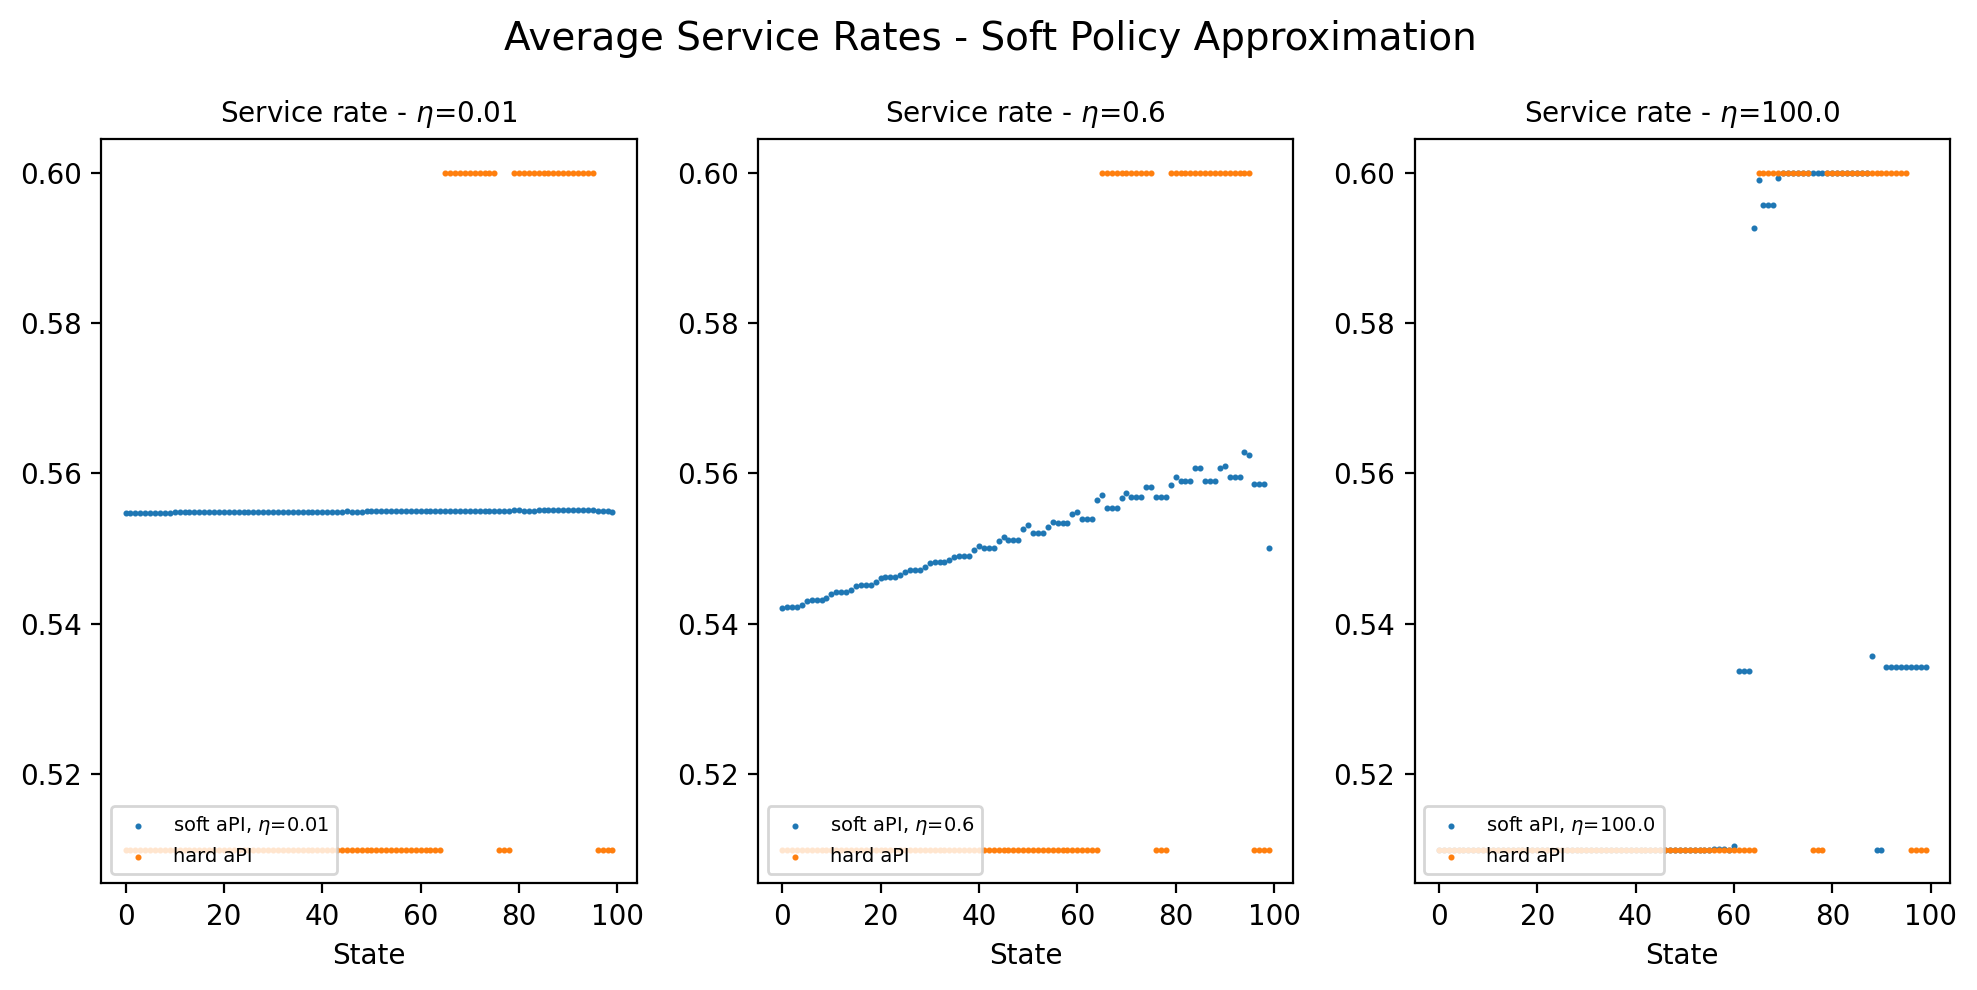

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5), dpi=200)

ax[0].scatter(np.arange(100),service_rates_PI.iloc[:,0], label = 'soft aPI, $\eta$='+str(round(etas[0],2)), s=1.4)
ax[0].scatter(np.arange(100),service_rates_PI['hard_aPI'], label = 'hard aPI', s=1.4) 
ax[0].set_title('Service rate - $\eta$='+str(round(etas[0],2)), fontsize = 10)
ax[0].legend(loc='lower left', prop={'size': 7})
                  
ax[1].scatter(np.arange(100),service_rates_PI.iloc[:,4], label = 'soft aPI, $\eta$='+str(round(etas[4],2)), s=1.4)
ax[1].scatter(np.arange(100),service_rates_PI['hard_aPI'], label = 'hard aPI', s=1.4) 
ax[1].set_title('Service rate - $\eta$='+str(round(etas[4],2)), fontsize = 10)
ax[1].legend(loc='lower left', prop={'size': 7})
                  
ax[2].scatter(np.arange(100),service_rates_PI.iloc[:,9], label = 'soft aPI, $\eta$='+str(round(etas[9],2)), s=1.4)
ax[2].scatter(np.arange(100),service_rates_PI['hard_aPI'], label = 'hard aPI', s=1.4) 
ax[2].set_title('Service rate - $\eta$='+str(round(etas[9],2)), fontsize = 10)
ax[2].legend(loc='lower left', prop={'size': 7})

for axs in ax.flat:
    axs.set(xlabel='State')
fig.suptitle('Average Service Rates - Soft Policy Approximation', fontsize=14)

plt.tight_layout()
plt.show()

### Compare value functions

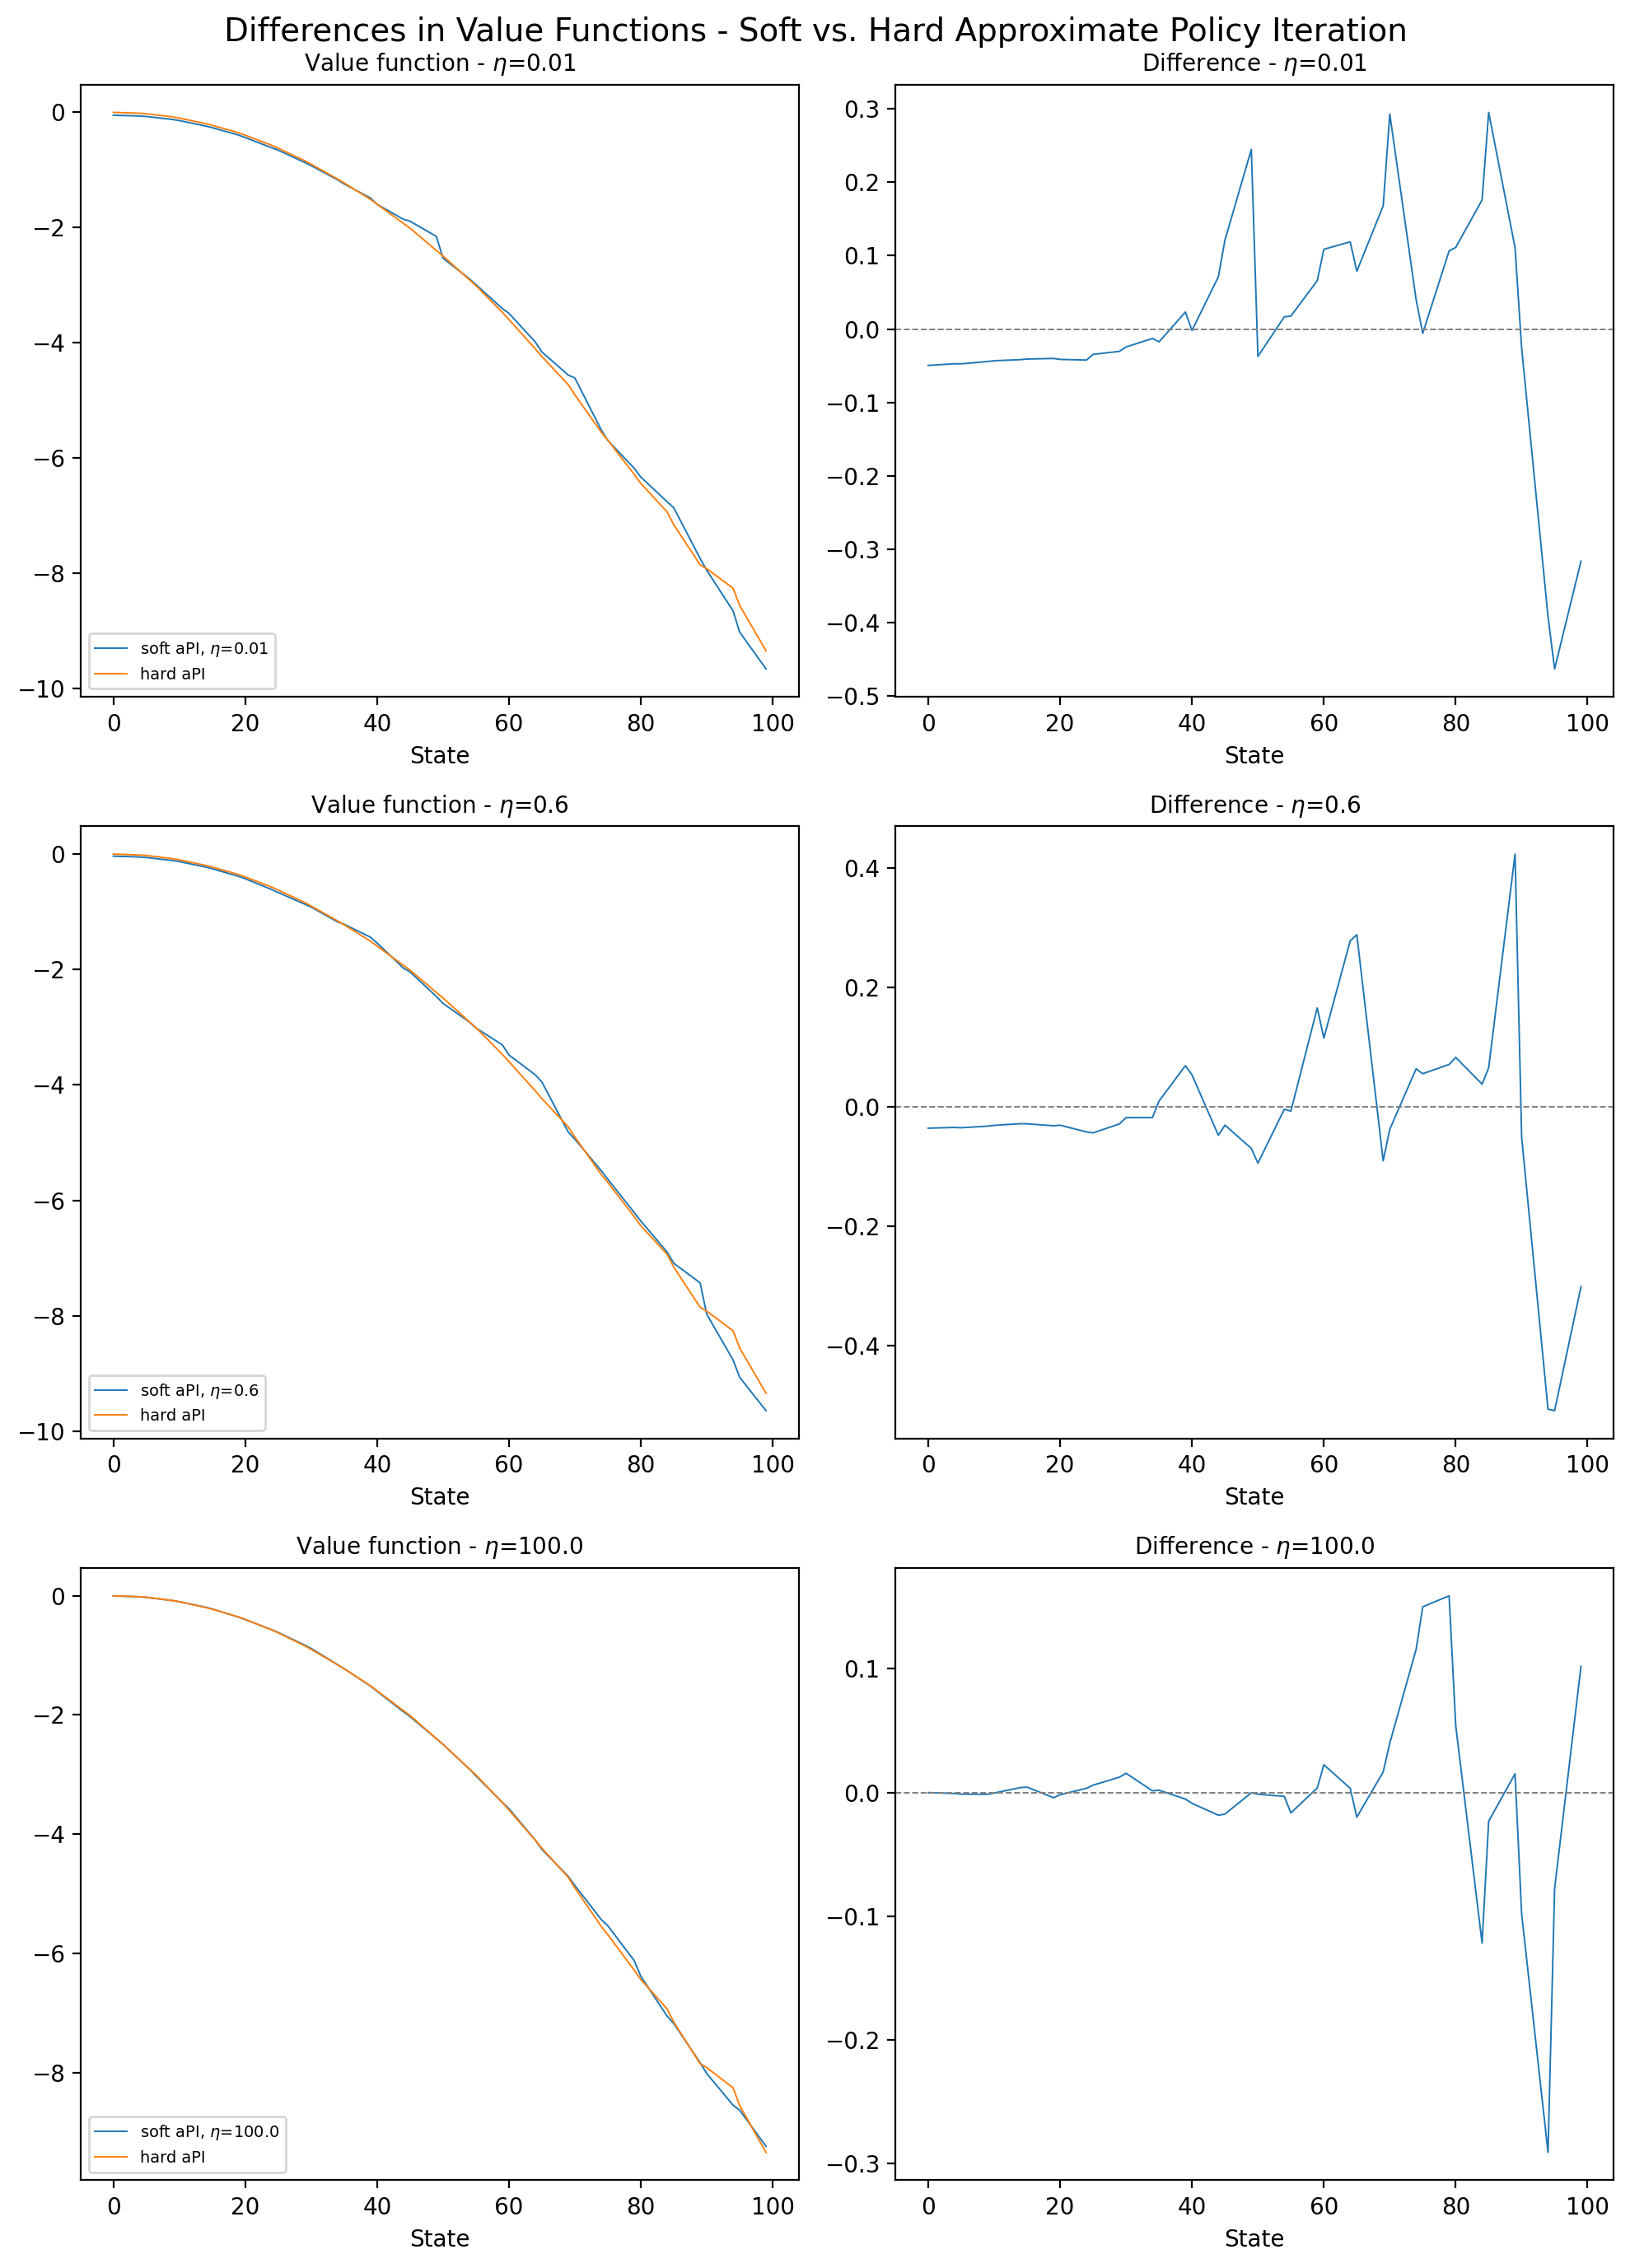

In [23]:
# look at differences in value functions for best performing policy
fig, ax = plt.subplots(3, 2, figsize=(10, 14), dpi=200)
ax[0,0].plot(np.arange(100),results_PI.iloc[:,0], label = 'soft aPI, $\eta$='+str(round(etas[0],2)), linewidth=0.7)
ax[0,0].plot(np.arange(100),results_PI['hard_aPI'], label = 'hard aPI', linewidth=0.7) 
ax[0,0].set_title('Value function - $\eta$='+str(round(etas[0],2)), fontsize = 10)
ax[0,0].legend(loc='lower left', prop={'size': 7})

ax[0,1].plot(np.arange(100),results_PI.iloc[:,0]-results_PI['hard_aPI'], label = 'soft aPI, $\eta$='+str(round(etas[0],2)), linewidth=0.7)
ax[0,1].axhline(y=0, linestyle="--", color="grey", linewidth=0.7)
ax[0,1].set_title('Difference - $\eta$='+str(round(etas[0],2)), fontsize = 10)
              
ax[1,0].plot(np.arange(100),results_PI.iloc[:,4], label = 'soft aPI, $\eta$='+str(round(etas[4],2)), linewidth=0.7)
ax[1,0].plot(np.arange(100),results_PI['hard_aPI'], label = 'hard aPI', linewidth=0.7) 
ax[1,0].set_title('Value function - $\eta$='+str(round(etas[4],2)), fontsize = 10)
ax[1,0].legend(loc='lower left', prop={'size': 7})

ax[1,1].plot(np.arange(100),results_PI.iloc[:,4]-results_PI['hard_aPI'], label = 'soft aPI, $\eta$='+str(round(etas[4],2)), linewidth=0.7)
ax[1,1].axhline(y=0, linestyle="--", color="grey", linewidth=0.7)
ax[1,1].set_title('Difference - $\eta$='+str(round(etas[4],2)), fontsize = 10)
                 
ax[2,0].plot(np.arange(100),results_PI.iloc[:,9], label = 'soft aPI, $\eta$='+str(round(etas[9],2)), linewidth=0.7)
ax[2,0].plot(np.arange(100),results_PI['hard_aPI'], label = 'hard aPI', linewidth=0.7) 
ax[2,0].set_title('Value function - $\eta$='+str(round(etas[9],2)), fontsize = 10)
ax[2,0].legend(loc='lower left', prop={'size': 7})

ax[2,1].plot(np.arange(100),results_PI.iloc[:,9]-results_PI['hard_aPI'], label = 'soft aPI, $\eta$='+str(round(etas[9],2)), linewidth=0.7)
ax[2,1].axhline(y=0, linestyle="--", color="grey", linewidth=0.7)
ax[2,1].set_title('Difference - $\eta$='+str(round(etas[9],2)), fontsize = 10)

for axs in ax.flat:
    axs.set(xlabel='State')
fig.suptitle('Differences in Value Functions - Soft vs. Hard Approximate Policy Iteration', fontsize=14)

plt.tight_layout()
plt.show()


### Answer
***Is there any improvement over "hard" approximate policy iteration for some value of $\eta$?***

From the graphs we see that hard and soft policy iteration perform similarly across all states and for all values of $\eta$. Both policy iteration algorithms switch to the high service rate for high states, although we see some fluctuation for the hard approximate policy iteration. For $\eta=100$, we see that the soft greedy policy switches back to the low service rate for a queue length above 90. Comparing the value functions of the two algorithms, I find that the smooth policy iteration algorithm performs slight worse for higher states when compared to the hard policy iteration algorithm, but has slightly better values for medium states. Note however that these differences are marginal. Overall, the soft approximate policy iteration algorithm does not constitute a significant improvement over the "hard" approximate policy iteration for the given deterministic environment.